In [1]:
import os
import time
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K
import time as t_lib
import tensorflow as tf
from threading import Thread
from IPython.display import clear_output
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
DATAFRAME_NAME = 'EURUSD_m15_Ask_ready.csv'
NUMBER_OF_SAMPLES = 50

EPISODES = 5000
TICQTY_MAX = 55000
HOLD_REWARD = -5
OPEN_TRADE_REWARD = 0
CLOSING_TRADE_WITH_OPENING = 20
DIVIDE_PRICE_UNDER_LOCAL_MINIMA = 10
REWARD_FOR_PIPS = 10000
TIMES_FACTOR = 10

ACTION_DECODE = {
    0: 0,
    1: 0.5,
    2: 1,
}


In [3]:
class Dataframe:

    def __init__(self):
        self._dataframe = self._load()[0:2000]
        self.__scaler = MinMaxScaler()

    @property
    def lenght(self):
        return len(self._dataframe.index) - NUMBER_OF_SAMPLES

    def get(self, sample_number):
        if sample_number > self.lenght or sample_number < 0:
            raise ValueError("Sample number out of range (0 - {self.lenght})")

        start_index = sample_number
        end_index = start_index + NUMBER_OF_SAMPLES

        df_sample = self._dataframe[start_index: end_index]

        last_open = df_sample.at[df_sample.index[-1], 'open']
        last_close = df_sample.at[df_sample.index[-1], 'close']

        df_sample = df_sample[['open', 'close', 'high', 'low', 'tickqty', 'hours', 'minutes']].values
        df_sample = self._scale(df_sample, start=0, end=4)
        return np.expand_dims(df_sample, axis=0), last_open, last_close

    @staticmethod
    def _load():
        """ Creating relative path and then loading the df_path """
        """
        df_path = os.path.join(os.path.dirname(os.path.abspath(__file__)) +
                               os.path.normpath(f'/dfs/{cfg.DATAFRAME_NAME}'))
        """
        df_path = './dfs/{}'.format(DATAFRAME_NAME)
        df = pd.read_csv(
            df_path,
            dtype={
                'datetime'
                'open': np.float32,
                'close': np.float32,
                'high': np.float32,
                'low': np.float32,
                'tickqty': np.float32,
            }
        )

        # df['hours']= pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f').dt.hour / 24
        df['hours'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.hour / 24
        df['minutes'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.minute / 64
        df['tickqty'] = df['tickqty'] / TICQTY_MAX
        return df

    def _scale(self, array: np.ndarray, start: int, end: int):
        columns = array.T[start: end].T

        self.__scaler.fit(columns)
        scaled_cols = self.__scaler.transform(columns).T
        array.T[start:end] = scaled_cols
        return array

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.sample_memory = deque()
        
        self.gamma = 0.99  # discount rate
        
        self.epsilon = 0 # exploration rate
        self.epsilon_min = 0.1
        self.epsilon_decay = 0.99995
        
        self.learning_rate = 0.006
        self.learning_rate_decay = 0.99995
        self.learning_rate_min = 0.0001
        
        self.batch_size_samples = 500
        self.batch_size = batch_size
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning

    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))

        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.sample_memory.append((state, action, reward, next_state, done))
    
    def train_from_iterations(self):
        while True:
            if len(self.sample_memory) != 0:
                state, action, reward, next_state, done = self.sample_memory.popleft()
                self.train(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(state, steps=1, verbose=0)
        if done and reward > 80 * TIMES_FACTOR:
            target[0][action] = reward
        else:
            # a = self.model.predict(next_state)[0]
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + self.gamma * np.amax(t)
            # target[0][action] = reward + self.gamma * t[np.argmax(a)]
        self.model.fit(state, target, epochs=1, verbose=0)
        # print('done')

    def act(self, state):
        if not isinstance(state, np.ndarray):
            return 0

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size), True
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0]), False  # returns action

    def predict(self, state):
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0])  # returns action

    def replay(self):
        while True:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                if not isinstance(state, np.ndarray):
                    continue
                
                self.train(state, action, reward, next_state, done)
                """
                target = self.model.predict(state, steps=1, verbose=0)
                if done and reward > 80 * TIMES_FACTOR:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
                """
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min
            
            if self.learning_rate > self.learning_rate_min:
                self.learning_rate *= self.learning_rate_decay
            else:
                self.learning_rate = self.learning_rate_min
            # print('done')
    
    def set_learning_rate(self):
        K.set_value(self.model.optimizer.lr, self.learning_rate)  # set new lr
        K.set_value(self.target_model.optimizer.lr, self.learning_rate)  # set new lr

    def load(self, name):
        self.model.load_weights(name)
        self.model._make_predict_function()
        self.model._make_test_function()
        self.model._make_train_function()

        self.target_model.load_weights(name)
        self.target_model._make_predict_function()
        self.target_model._make_test_function()
        self.target_model._make_train_function()

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
class Trevor:
    POSITIVE_TIMES_REWARD = 0.00001
    NEGATIVE_TIMES_REWARD = 0.00001

    def __init__(self, df):
        self.df = df

        self.cursor = 0
        self.enter_price = 0
        self.local_max_price = 0

        self.last_action = 0

        self.closed_counter = 0
        self.total_reward = 0
        self.trade_counter = 0

        self.closed_counter_list = []

    def reset(self):
        self.cursor = 0
        self.enter_price = 0
        self.last_action = 0
        self.closed_counter = 0
        self.trade_counter = 0
        self.total_reward = 0
        # self.reset_closed_list()

        return self.step(0)[0]

    def step(self, action):
        sample, last_open, last_close = self.df.get(self.cursor)

        reward, closing_trade = self.__process_action(action=action, last_close=last_close)
        sample = self.__append_last_action(sample=sample, action=action, last_close=last_close)

        self.__increment_cursor()

        return sample, reward, closing_trade, ''

    def get_total_reward(self):
        return self.total_reward

    def reset_closed_list(self):
        self.closed_counter_list = []

    def plot(self, title):
        x = list(range(1, len(self.closed_counter_list) + 1))
        pyplot.plot(x, self.closed_counter_list)
        pyplot.title(str(title))
        pyplot.show()

    def __process_action(self, action, last_close):
        if action < 0 or action > 2:
            raise ValueError('Action have to be inrage (0 - 2) got {action}')

        closing_trade = False

        # """ CLOSING POSITION """
        if (self.last_action == 2 and action == 0) or (self.last_action == 1 and action == 0):
            reward = self.__close_trade(last_close=last_close)
            closing_trade = True

        # """ CLOSING POSITION AND GOING TO DIFFERENT POSITION """
        elif (self.last_action == 2 and action == 1) or (self.last_action == 1 and action == 2):
            reward = self.__close_trade(last_close=last_close) - CLOSING_TRADE_WITH_OPENING
            self.enter_price = last_close
            self.local_max_price = last_close
            closing_trade = True

        # """ HOLDING OPENED POSITION  """
        elif (self.last_action == 2 and action == 2) or (self.last_action == 1 and action == 1):
            if self.last_action == 2:
                reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                """
                if self.local_max_price < last_close:
                    reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (last_close - self.local_max_price) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close > self.enter_price \
                        else reward
                """

            else:
                reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                """
                if self.local_max_price > last_close:
                    reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (self.local_max_price - last_close) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close < self.enter_price \
                        else reward
                """

        # """ OPENING POSITION  """
        elif (self.last_action == 0 and action == 1) or (self.last_action == 0 and action == 2):
            self.enter_price = last_close
            self.local_max_price = last_close
            reward = OPEN_TRADE_REWARD

        # """ HOLD """
        elif self.last_action == 0 and action == 0:
            reward = HOLD_REWARD

        else:
            raise ValueError('Last action = {self.last_action} and actual_action = {action}')

        self.last_action = action
        self.total_reward += reward
        return reward, closing_trade

    def __increment_cursor(self):
        """ Incrementing the cursor, if the cursor is bigger than lenght of the dataframe, then reset it"""

        self.cursor += 1
        if self.cursor > self.df.lenght:
            self.cursor = 0

    def __close_trade(self, last_close):
        if self.last_action == 2:
            reward = (last_close - self.enter_price) * REWARD_FOR_PIPS * TIMES_FACTOR
            self.closed_counter += reward / TIMES_FACTOR
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        else:
            reward = (self.enter_price - last_close) * REWARD_FOR_PIPS * TIMES_FACTOR
            self.closed_counter += reward / TIMES_FACTOR
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        self.closed_counter_list.append(self.closed_counter)
        self.trade_counter += 1
        return reward

    def __append_last_action(self, sample: np.ndarray, action: int, last_close: float):
        how_many = sample.shape[1]
        decoded_action = ACTION_DECODE[action]

        action_arr = (np.expand_dims(np.asarray([decoded_action for i in range(0, how_many)]), axis=1))

        if action == 2 or action == 1:
            dif = (last_close - self.enter_price)
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        else:
            dif = 0
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        sample = np.append(sample[0], action_arr, axis=1)
        sample = np.append(sample, pip_difference, axis=1)

        return np.expand_dims(sample, axis=0)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Actual reward = 0	, total reward = -5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = -4.6	, total reward = -9.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = -5.2	, total reward = -14.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = -7.5	, total reward = -22.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = -7.2	, total reward = -29.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = -4.0	, total reward = -33.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 2.0	, total reward = -31.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 2.9	, total reward = -28.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 8.4	, total reward = -20.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 5.8	, total reward = -14.4,	 action =

Actual reward = 64.3	, total reward = 2431.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 68.6	, total reward = 2499.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 64.2	, total reward = 2564.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 65.5	, total reward = 2629.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 62.6	, total reward = 2692.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 63.3	, total reward = 2755.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 54.6	, total reward = 2810.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 56.2	, total reward = 2866.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 62.3	, total reward = 2928.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 64.4	, total reward = 2993.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 59.8	, total reward = 3052.8,	 action = 2	 t

Actual reward = 73.8	, total reward = 8566.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 68.9	, total reward = 8635.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 64.8	, total reward = 8699.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 64.1	, total reward = 8764.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 61.3	, total reward = 8825.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 64.8	, total reward = 8890.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 68.1	, total reward = 8958.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 66.4	, total reward = 9024.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 64.9	, total reward = 9089.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 67.6	, total reward = 9157.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 62.7	, total reward = 9219.8,	 action = 2	 t

Actual reward = 133.1	, total reward = 16862.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 131.6	, total reward = 16994.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 131.8	, total reward = 17125.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 132.2	, total reward = 17258.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 132.0	, total reward = 17390.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 132.4	, total reward = 17522.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 134.6	, total reward = 17657.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 133.7	, total reward = 17790.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 144.5	, total reward = 17935.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 141.6	, total reward = 18076.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 137.4	, total reward = 1

Actual reward = 108.0	, total reward = 28773.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 107.6	, total reward = 28881.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 109.6	, total reward = 28990.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 117.1	, total reward = 29107.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 119.0	, total reward = 29226.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 116.7	, total reward = 29343.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 111.6	, total reward = 29455.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 114.0	, total reward = 29569.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 105.7	, total reward = 29674.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 108.1	, total reward = 29783.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 105.9	, total reward = 2

Actual reward = 183.8	, total reward = 40263.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 186.3	, total reward = 40449.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 200.9	, total reward = 40650.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 188.7	, total reward = 40839.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 191.5	, total reward = 41030.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 196.3	, total reward = 41227.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 194.9	, total reward = 41422.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 197.5	, total reward = 41619.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 196.5	, total reward = 41816.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 197.3	, total reward = 42013.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 198.2	, total reward = 4

Actual reward = 182.8	, total reward = 59717.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 187.3	, total reward = 59905.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 187.5	, total reward = 60092.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 177.0	, total reward = 60269.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 176.9	, total reward = 60446.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 181.3	, total reward = 60627.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 177.2	, total reward = 60805.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 175.6	, total reward = 60980.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 170.5	, total reward = 61151.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 170.7	, total reward = 61321.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 175.0	, total reward = 6

Actual reward = 142.3	, total reward = 77003.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 137.9	, total reward = 77141.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 136.6	, total reward = 77278.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 132.1	, total reward = 77410.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 142.9	, total reward = 77553.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 146.0	, total reward = 77699.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 147.2	, total reward = 77846.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 144.1	, total reward = 77990.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 147.2	, total reward = 78137.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 141.6	, total reward = 78279.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 141.2	, total reward = 7

Actual reward = 122.3	, total reward = 90218.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 127.2	, total reward = 90345.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 130.3	, total reward = 90476.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 132.2	, total reward = 90608.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 129.4	, total reward = 90737.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 133.4	, total reward = 90871.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 132.1	, total reward = 91003.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 135.3	, total reward = 91138.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 141.8	, total reward = 91280.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 141.6	, total reward = 91421.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 143.9	, total reward = 9

Actual reward = 110.9	, total reward = 102918.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 95.2	, total reward = 103014.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 102.4	, total reward = 103116.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 103.8	, total reward = 103220.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 64.4	, total reward = 103284.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 59.0	, total reward = 103343.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 53.0	, total reward = 103396.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 57.2	, total reward = 103453.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 60.7	, total reward = 103514.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 54.2	, total reward = 103568.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 52.8	, total reward =

Actual reward = 64.9	, total reward = 109480.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 66.8	, total reward = 109547.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 59.0	, total reward = 109606.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 67.5	, total reward = 109674.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 67.5	, total reward = 109741.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 69.3	, total reward = 109810.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 72.3	, total reward = 109883.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 68.4	, total reward = 109951.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 72.1	, total reward = 110023.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 64.4	, total reward = 110088.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 64.2	, total reward = 11

Actual reward = 51.7	, total reward = 115103.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 54.9	, total reward = 115158.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 57.6	, total reward = 115215.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 40.3	, total reward = 115256.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 45.2	, total reward = 115301.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 46.7	, total reward = 115348.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 50.9	, total reward = 115398.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 48.3	, total reward = 115447.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 49.9	, total reward = 115497.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 49.3	, total reward = 115546.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 50.3	, total reward = 11

Actual reward = 44.5	, total reward = 120600.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 38.9	, total reward = 120638.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 41.0	, total reward = 120679.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 28.3	, total reward = 120708.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 26.1	, total reward = 120734.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 32.0	, total reward = 120766.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 22.5	, total reward = 120788.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 21.7	, total reward = 120810.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 29.3	, total reward = 120839.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 26.9	, total reward = 120866.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 24.6	, total reward = 12

Actual reward = 26.1	, total reward = 123995.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 24.8	, total reward = 124020.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 26.0	, total reward = 124046.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 24.1	, total reward = 124070.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 24.8	, total reward = 124095.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 28.8	, total reward = 124123.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 29.1	, total reward = 124152.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 30.0	, total reward = 124182.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 24.9	, total reward = 124207.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 29.1	, total reward = 124236.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 28.0	, total reward = 12

Actual reward = 10.5	, total reward = 126752.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 8.9	, total reward = 126761.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 10.7	, total reward = 126772.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 15.4	, total reward = 126787.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 20.1	, total reward = 126807.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 27.0	, total reward = 126834.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 24.0	, total reward = 126858.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 27.0	, total reward = 126885.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 21.0	, total reward = 126906.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 25.1	, total reward = 126931.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 24.9	, total reward = 126

Actual reward = 22.5	, total reward = 129387.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 19.3	, total reward = 129406.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 19.4	, total reward = 129426.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 23.5	, total reward = 129449.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 26.8	, total reward = 129476.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 27.6	, total reward = 129504.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 31.1	, total reward = 129535.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 30.5	, total reward = 129565.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 51.9	, total reward = 129617.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 43.7	, total reward = 129661.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 50.1	, total reward = 12

Actual reward = 0.2	, total reward = 133125.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 29.5	, total reward = 133155.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 34.4	, total reward = 133189.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 34.0	, total reward = 133223.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 42.6	, total reward = 133266.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 32.1	, total reward = 133298.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 33.4	, total reward = 133331.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 25.1	, total reward = 133356.7,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 18.8	, total reward = 133375.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 8.7	, total reward = 133384.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 10.1	, total reward = 1333

Actual reward = 21.9	, total reward = 132028.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 31.7	, total reward = 132060.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 35.5	, total reward = 132096.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 47.0	, total reward = 132143.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 43.7	, total reward = 132186.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 46.3	, total reward = 132233.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 67.7	, total reward = 132300.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 68.8	, total reward = 132369.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 61.9	, total reward = 132431.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 66.3	, total reward = 132497.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 74.3	, total reward = 13

Actual reward = 78.8	, total reward = 139071.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 77.1	, total reward = 139148.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 79.6	, total reward = 139227.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 76.6	, total reward = 139304.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 82.9	, total reward = 139387.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 84.6	, total reward = 139472.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 81.5	, total reward = 139553.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 81.9	, total reward = 139635.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 82.7	, total reward = 139718.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 74.1	, total reward = 139792.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 83.3	, total reward = 13

Actual reward = 98.2	, total reward = 148101.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 100.7	, total reward = 148201.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 97.7	, total reward = 148299.5,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 93.7	, total reward = 148393.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 92.2	, total reward = 148485.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 89.4	, total reward = 148574.8,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 86.3	, total reward = 148661.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 85.9	, total reward = 148747.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 84.3	, total reward = 148831.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 90.8	, total reward = 148922.1,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 90.6	, total reward = 1

Actual reward = 93.5	, total reward = 157289.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 94.3	, total reward = 157383.6,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 98.3	, total reward = 157481.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 104.4	, total reward = 157586.3,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 104.1	, total reward = 157690.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 102.0	, total reward = 157792.4,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 95.8	, total reward = 157888.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 93.7	, total reward = 157981.9,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 89.3	, total reward = 158071.2,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 94.8	, total reward = 158166.0,	 action = 2	 trade_counter = 0	 pip_counter = 0
Actual reward = 90.3	, total reward =

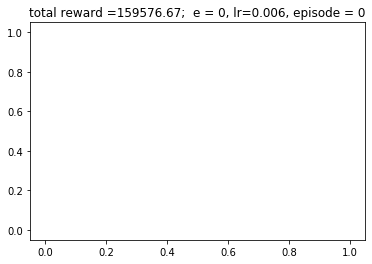

Waiting to train the whole dataset


In [ ]:
env = Trevor(Dataframe())
state_size = (NUMBER_OF_SAMPLES, 9)
action_size = 3
batch_size = 32
agent = DQNAgent(state_size, action_size, batch_size)

# agent.save("./save/cartpole-ddqn.h5")
agent.load("./save/cartpole-ddqn.h5")

closed = False
run = False

for e in range(EPISODES):
    state = env.reset()
    strt = t_lib.time()
    
    for time in range(env.df.lenght):
        action, random_action = agent.act(state)

        if action > 3 or action < 0:
            print('Got action ' + action)
            continue

        next_state, reward, closed, _ = env.step(action)

        if not isinstance(next_state, np.ndarray) or not(state, np.ndarray):
            print(next_state)
            print('NOT NUMPY!!')
            continue

        agent.memorize(state=state, action=action, reward=reward, next_state=next_state, done=closed)
        state = next_state
        
        """
        print(f'Actual reward = {round(reward, 1)},\t total reward = {round(env.total_reward, 1)},'
              f'\t action = {action}, \t trade_counter = {round(env.trade_counter, 1)}, '
              f'\t pip_counter = {round(env.closed_counter, 1)}'
              f'\t random_action = {random_action}'
              f'\t candle_number = {time}')
        """
        print("Actual reward = {}\t, total reward = {},\t action = {}\t trade_counter = {}\t pip_counter = {}".format(round(reward, 1), round(env.total_reward, 1), action, round(env.trade_counter, 1), round(env.closed_counter, 1)))
        if closed and reward > 80 * TIMES_FACTOR:
            agent.update_target_model()
            """
            print("episode: {}/{}, score: {}, e: {}, lr: {}"
                  .format(e, EPISODES, time, round(agent.epsilon, 2)), round(agent.learning_rate, 2))
            """
            print('{} pips on candle {}'.format(round(reward / TIMES_FACTOR), time))
        
        """
        if len(agent.memory) > batch_size:
            # agent.replay(batch_size)
            if not run:
                thr_list = [Thread(target=agent.replay) for _ in range(1)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                    
                thr_list = [Thread(target=agent.train_from_iterations) for _ in range(5)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                
                run = True
        """
                
    # clear_output()
    env.plot(title='total reward ={};  e = {}, lr={}, episode = {}'.format(round(env.total_reward, 2), round(agent.epsilon, 4), round(agent.learning_rate, 7), e))
    env.reset_closed_list()
    print('Waiting to train the whole dataset')
    while not len(agent.sample_memory) == 0:
        pass
    agent.set_learning_rate()
    print('DONE, lets roll!!')
    agent.save("./save/cartpole-ddqn.h5")
    print(round(t_lib.time() - strt, 3))